# Ficha de trabalho - Clustering e redução dimensionalidade
Ficheiros a usar: 
* wines.csv - ficheiro com os dados das análises
* wines_labels.csv - labels das classes


**Sumário:**

A data frame containing 177 rows and thirteen columns. These data are the results of chemical analyses of wines grown in the same region in Italy (Piedmont) but derived from three different cultivars (classes).


In [2]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
from sklearn import preprocessing
from scipy.cluster.hierarchy import dendrogram, linkage

#### Ex.1) Importa os dados presentes nos dois ficheiros.

In [3]:
data = pd.read_csv("wines.csv", sep=",", index_col=0)
meta = pd.read_csv("wines_labels.csv", sep=",", index_col=0)

#### Ex.2)  Explora o dataset, indicando:
 * o número de amostras e atributos, 
 * tipos de dados, 
 * se há valores em falta.

In [4]:
# Número de amostras e atributos
print(data.shape)
print(meta.shape)

(177, 13)
(177, 1)


In [5]:
#Tipos de dados
type(data)

pandas.core.frame.DataFrame

In [6]:
#Valores omissos
data.isnull().sum().sum()

0

#### Ex.3) Verifica se as amostras provenientes das classes "Barolo" e "Barbera" têm níveis de alcool significativamente diferentes.

In [14]:
data_barolo = data[meta["x"] == "Barolo"]
barolo_alchohol = data_barolo.alcohol

data_barbera = data[meta["x"] == "Barbera"]
barbera_alchohol = data_barbera.alcohol

barolo_alchohol_log = np.log2(barolo_alchohol)
barbera_alchohol_log = np.log2(barbera_alchohol)

In [15]:
from scipy import stats

#H0: There isn't a statistically meaningfull difference between the means of the groups.
#H1: There is a statistically meaningfull difference between the means of the groups

t_test, p_value = stats.mannwhitneyu(barolo_alchohol_log, barbera_alchohol_log)
p_value
#As the p value is superior to 0,05, we accept the null hypothesis. Therefore, the two groups have a similar mean.

2.4637542537203544e-07

#### Ex.4) Efectua uma análise semelhante à anterior mas considerando também a classe “Grignolino”.

In [16]:
data_grignolino = data[meta["x"] == "Grignolino"]
data_grignolino_alchohol = data_grignolino.alcohol
grignolino_alchohol_log = np.log2(data_grignolino_alchohol)

#H0: There isn't a statistically meaningfull difference between the means of the groups.
#H1: There is a statistically meaningfull difference between the means of the groups

t_test, p_value = stats.f_oneway(barolo_alchohol_log, barbera_alchohol_log, grignolino_alchohol_log)
p_value
#As the p value is superior to 0,05, we accept the null hypothesis. Therefore, the two groups have a similar mean.

8.781929512643617e-36

#### Ex.5) Realiza um PCA e determine quantos componentes principais são necessários para explicar 90% da variabilidade dos dados. Representa os scores num gráfico onde as cores dos pontos variam consoante a classe a que a amostra pertence. O que conclui em relação à discriminação das respetivas classes?

In [20]:
from statsmodels.multivariate import pca
from sklearn.decomposition import PCA

wine_scale = preprocessing.scale(data.iloc[:,:13])
wine_scale

n_components = min(177, 13)
pca_wine = PCA(n_components)
pca_wine.fit(wine_scale)
x_reduced=pca_wine.transform(wine_scale)

print(pca_wine.explained_variance_ratio_)

[0.35983071 0.1924128  0.1117946  0.07111109 0.06628744 0.04960367
 0.04246014 0.02697991 0.02224462 0.01898528 0.01734155 0.01295206
 0.00799613]


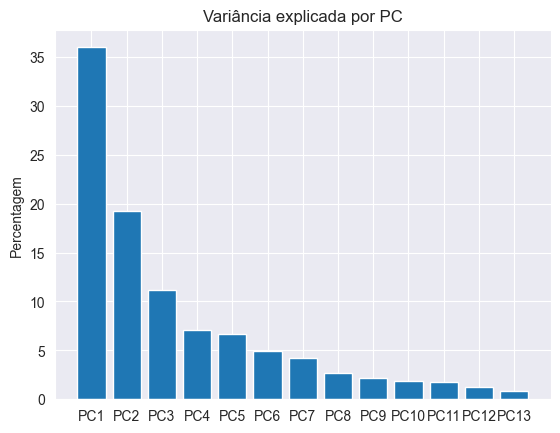

In [23]:
plt.bar(range(n_components), pca_wine.explained_variance_ratio_*100)
plt.xticks(range(n_components), ['PC'+str(i) for i in range(1, n_components+1)])
plt.title("Variância explicada por PC")
plt.ylabel("Percentagem")
plt.show()

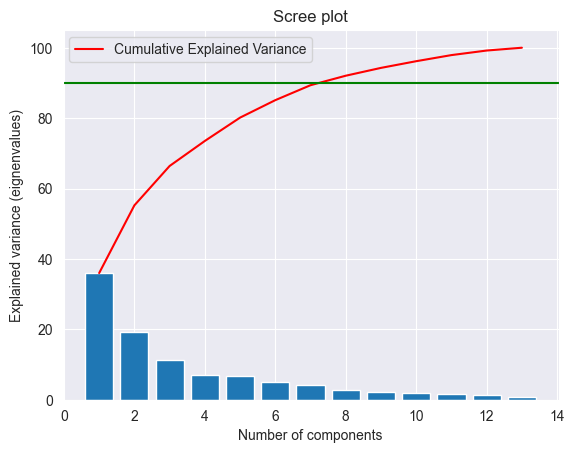

In [24]:
import numpy as np

plt.bar(
    range(1,len(pca_wine.explained_variance_ratio_*100)+1),
    pca_wine.explained_variance_ratio_*100
    )

plt.plot(
    range(1,len(pca_wine.explained_variance_ratio_*100)+1),
    np.cumsum(pca_wine.explained_variance_ratio_*100),
    c='red',
    label='Cumulative Explained Variance')

plt.legend(loc='upper left')
plt.xlabel('Number of components')
plt.ylabel('Explained variance (eignenvalues)')
plt.axhline(y=90, c = "green")
plt.title('Scree plot')

plt.show()

Através da interpretação do gráfico podemos inferir que o número de componentes que explicam 90% da variabilidade são 7.

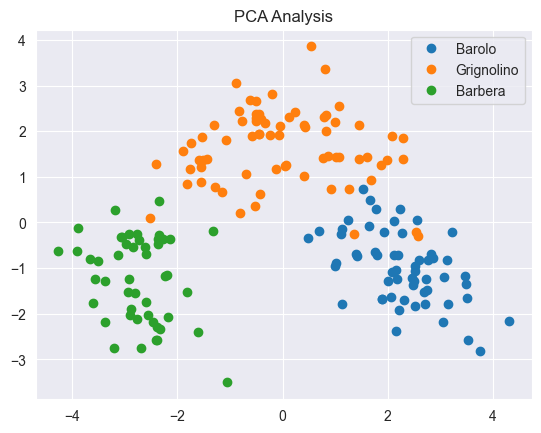

In [21]:
for casta in meta.x.unique():
    samples_index = meta.index[meta.x==casta]-1 # porque a indexação começa no 0
    plt.plot(x_reduced[samples_index, 0], x_reduced[samples_index,1], "o", label=casta)

plt.title("PCA Analysis")
plt.legend()
#As castas representam perfis bioquímicos diferentes que se refletem nisto.

#### Ex.6) Realizar clustering hierarquico dos dados, utilizando a métrica de distância "Manhattan”. Apresenta a àrvore resultante colorindo as folas de acordo com a classe. O que conclui olhando para os resultados?


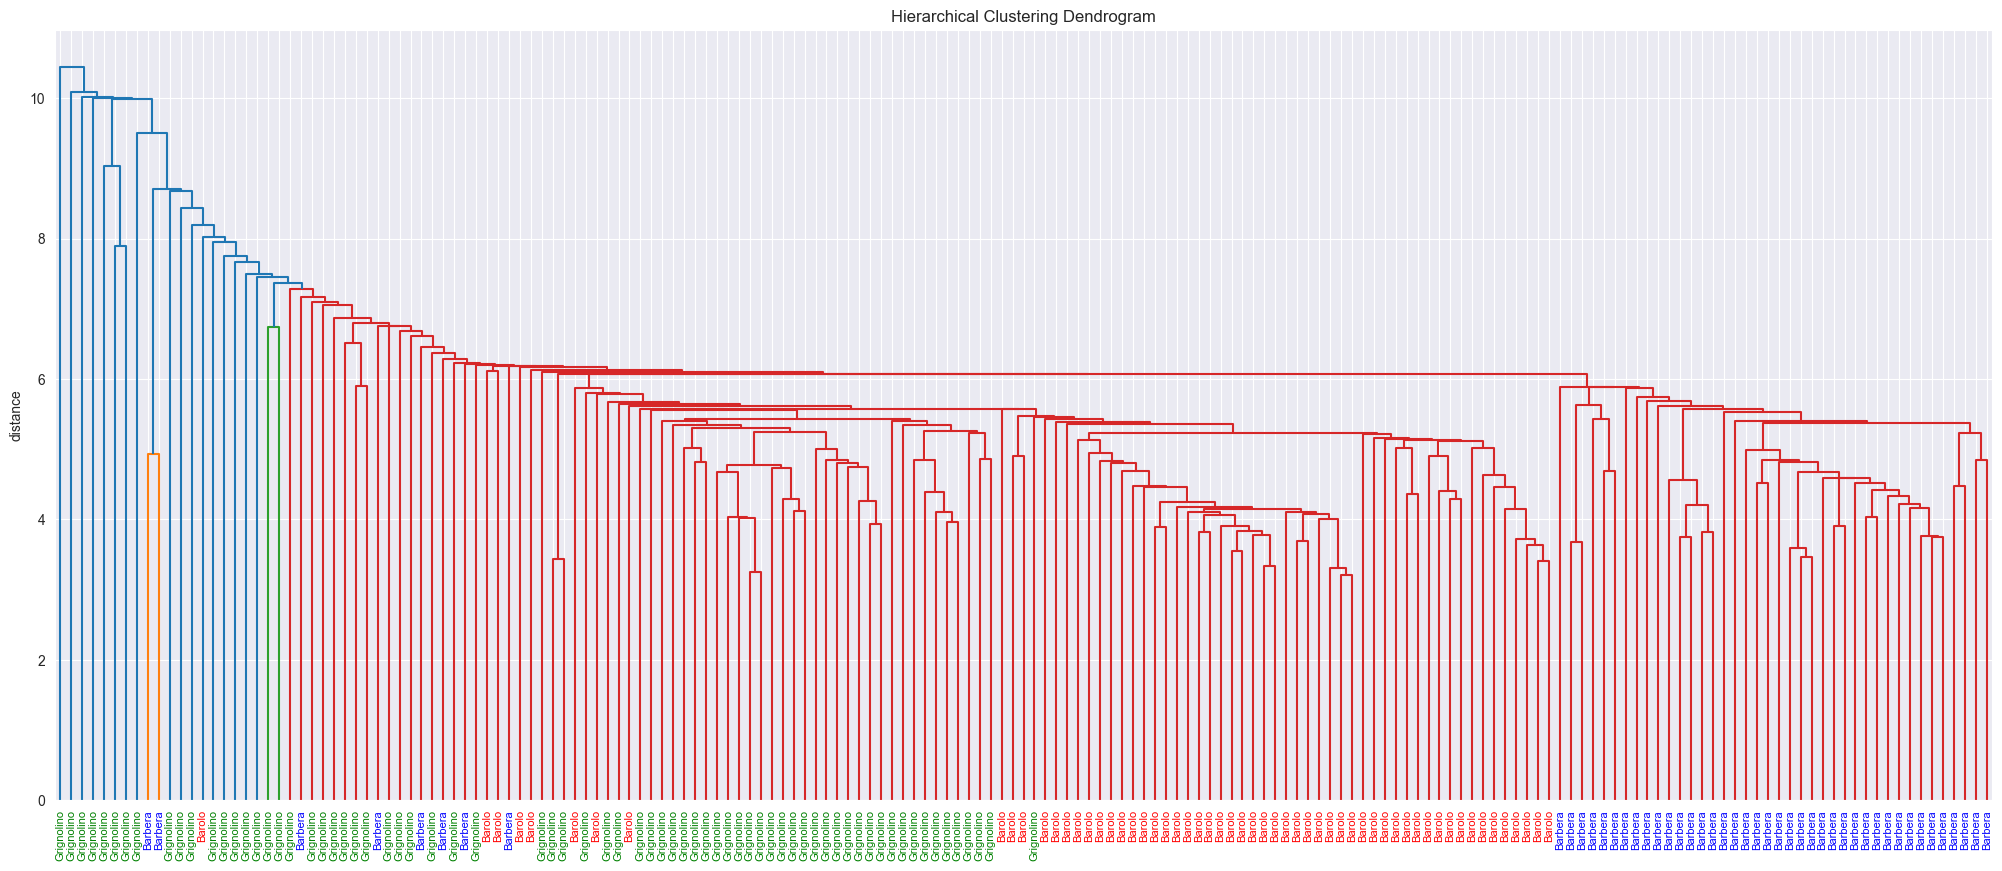

In [21]:
Z = linkage(wine_scale, method='single', metric='cityblock')

# calculate full dendrogram
plt.figure(figsize=(25, 10))
dendrogram(
    Z,
    labels=list(meta.iloc[:, -1]),
    leaf_rotation=90.,  # rotates the x-axis labels
    leaf_font_size=8.,  # font size for the x-axis labels
)

plt.title('Hierarchical Clustering Dendrogram')
plt.ylabel('distance')


# Assignment of colors to labels: 'a' is red, 'b' is green, etc.
label_colors = {'Barolo': 'r', 'Grignolino': 'g', 'Barbera': 'b'}
ax = plt.gca()
x_labels = ax.get_xmajorticklabels()
for lbl in x_labels:
    lbl.set_color(label_colors[lbl.get_text()])

plt.show()

A partir do gráfico podemos inferir que a casta Barbera e Grignolino são as mais similares, dado apresentarem uma menor distância entre elas. A casta Barolo e Barbera são também semelhantes apresentando uma distância pouco maior. Pelo contrário as castas Grignolino e Barolo apenas se unem (?).

#### Ex.7) Aplica a função de clustering k-means aos dados, com k =3, e compara os resultados com os presentes na variavel *wines_labels*. O que conclui desta análise? Cruze os resultados com os obtidos anteriormente.

In [22]:
from sklearn.cluster import KMeans

k=3
kmeans_wine = KMeans(n_clusters=k, max_iter=1000)
kmeans_wine.fit(wine_scale)
labels = kmeans_wine.labels_
centroids = kmeans_wine.cluster_centers_

pd.crosstab(labels, meta["x"], rownames=['clusters'] )

x,Barbera,Barolo,Grignolino
clusters,,,
0,48,0,3
1,0,58,3
2,0,0,65


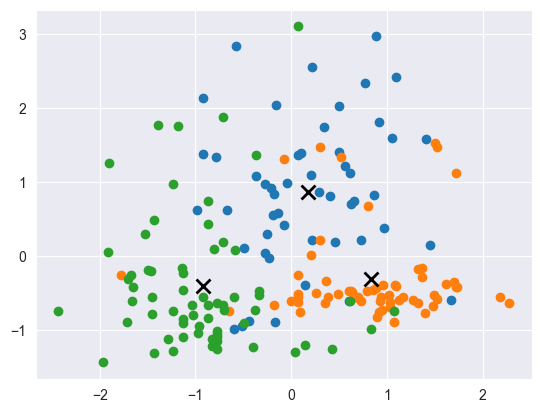

In [23]:
for i in range(k):
    # select only data observations with cluster label == i
    ds = wine_scale[np.where(labels == i)]
    # plot the data observations (only 2 first colums)
    plt.plot(ds[:, 0], ds[:, 1], 'o')
    # plot the centroids
    lines = plt.plot(centroids[i, 0], centroids[i, 1], 'kx')
    # make the centroid x's bigger
    plt.setp(lines, ms=10.0)  # x size
    plt.setp(lines, mew=2.0)  #grossura da linha
plt.show()